<a href="https://colab.research.google.com/github/jdasam/ant5015/blob/main/notebooks/5th_week_auto_tagging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autotagging

In [1]:
import torch
import torchaudio
import IPython.display as ipd
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

- Download Small MTAT if you need


In [2]:
!pip install --upgrade gdown
!gdown 15e9E3oZdudErkPKwb0rCAiZXkPxdZkV6
# !wget https://sogang365-my.sharepoint.com/:u:/g/personal/dasaem_jeong_o365_sogang_ac_kr/EdkHWV-qvxBEi-d0Ua73VG4BEp7EZO7HMvrXsWqeJvMJzg?e=GbYylV&download=1

!unzip -q mtat_8000.zip

  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3
Downloading...
From (original): https://drive.google.com/uc?id=15e9E3oZdudErkPKwb0rCAiZXkPxdZkV6
From (redirected): https://drive.google.com/uc?id=15e9E3oZdudErkPKwb0rCAiZXkPxdZkV6&confirm=t&uuid=fa9856af-cf25-48c9-bbbd-42e35a9a3e4f
To: /content/mtat_8000.zip
100% 921M/921M [00:08<00:00, 105MB/s]


In [3]:
class MTATDataset:
  def __init__(self, dir_path, split='train', num_max_data=6000, sr=16000):
    self.dir = Path(dir_path)
    self.labels = pd.read_csv(self.dir / "meta.csv", index_col=[0])
    self.sr = sr

    if split=="train":
      sub_dir_ids = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c']
    elif split=='valid':
      sub_dir_ids = ['d']
    elif split=='test': #test
      sub_dir_ids = ['e', 'f', 'g']
    else:
      raise NotImplementedError

    is_in_set = [True if x[0] in sub_dir_ids else False for x in self.labels['mp3_path'].values.astype('str')]
    self.labels = self.labels.iloc[is_in_set]
    self.labels = self.labels[:num_max_data]
    self.vocab = self.labels.columns.values[1:-1]
    self.label_tensor = self.convert_label_to_tensor()

  def convert_label_to_tensor(self):
    return torch.tensor(self.labels.values[:, 1:-1].astype('bool'), dtype=torch.float)

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    info = self.labels.iloc[idx]
    mp3_path = self.dir / info['mp3_path']

    audio, sr = torchaudio.load(mp3_path)
    assert sr == self.sr
    label = self.label_tensor[idx]
    return audio.mean(0), label

data_dir = Path('MTAT_SMALL')
dataset= MTATDataset(data_dir)
dataset[0]

(tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -8.8974e-08,
         -5.8156e-08, -5.6856e-08]),
 tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]))

In [4]:
csv_fn = 'MTAT_SMALL/meta.csv'
meta = pd.read_csv(csv_fn, index_col=[0])
meta

,clip_id,singer,harpsichord,sitar,heavy,foreign,no piano,classical,female,jazz,...,rock,dance,cello,techno,flute,beat,soft,choir,baroque,mp3_path
20552,45147,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,2/zephyrus-angelus-11-ave_maria__virgo_serena_...
3899,8539,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,a/tilopa-pictures_of_silence-02-ni-175-204.mp3
8996,19647,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5/arthur_yoria-of_the_lovely-04-several_mistak...
4055,8856,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8/stargarden-music_for_modern_listening-02-per...
6361,13834,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,a/dac_crowell-the_mechanism_of_starlight-03-me...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11433,25167,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,e/jeff_wahl-meditative_guitar-05-the_persisten...
4047,8845,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/satori-healing_sounds_of_tibet-02-passion_of...
2499,5418,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/dac_crowell-redshifted_harmonies-01-tranquil...
2342,5122,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,f/three_holies_church_choristers-the_hymns_of_...


In [5]:
audio, label = dataset[15]
ipd.display(ipd.Audio(audio, rate=16000))
dataset.vocab[torch.where(label)[0]]

array(['guitar', 'male'], dtype=object)

In [ ]:
dataset.vocab

array(['singer', 'harpsichord', 'sitar', 'heavy', 'foreign', 'no piano',
       'classical', 'female', 'jazz', 'guitar', 'quiet', 'solo', 'folk',
       'ambient', 'new age', 'synth', 'drum', 'bass', 'loud', 'string',
       'opera', 'fast', 'country', 'violin', 'electro', 'trance', 'chant',
       'strange', 'modern', 'hard', 'harp', 'pop', 'female vocal',
       'piano', 'orchestra', 'eastern', 'slow', 'male', 'vocal',
       'no singer', 'india', 'rock', 'dance', 'cello', 'techno', 'flute',
       'beat', 'soft', 'choir', 'baroque'], dtype=object)

In [6]:
import time

start_time = time.time()
for i in range(500):
  dataset[i]
end_time = time.time()
print(end_time - start_time)

8.112107515335083


## Make Dataset

## Make Model

In [8]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)
batch = next(iter(train_loader))
audios, labels = batch

In [95]:
import torch.nn as nn

class MelDbConverter(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.mel_conv = torchaudio.transforms.MelSpectrogram(n_fft=1024,
                                                     hop_length=512,
                                                     f_min=20,
                                                     f_max=4000,
                                                     n_mels=80,
                                                     sample_rate=16000)
    self.db_conv = torchaudio.transforms.AmplitudeToDB()

  def forward(self, x):
    return self.db_conv(self.mel_conv(x)) / 100



class CNNModel(nn.Module):
  def __init__(self, dim=8, num_out=10):
    super().__init__() # nn.Module init

    self.spec = MelDbConverter()
    self.layers = []
    in_channel = 1
    hidden_channel = dim
    for i in range(5):
      conv = nn.Conv2d(in_channels=in_channel, out_channels=hidden_channel, kernel_size=3, padding=1)
      self.layers.append(conv)
      self.layers.append(nn.BatchNorm2d(hidden_channel))
      self.layers.append(nn.ReLU())
      pool = nn.MaxPool2d(2)
      self.layers.append(pool)
      in_channel = hidden_channel
      hidden_channel *= 2
    self.layers = nn.Sequential(*self.layers)
    self.proj = nn.Linear(hidden_channel, num_out)

  def forward(self, x):
    # print(f"x.shape: {x.shape}")
    spec = self.spec(x)
    # print(f"spec.shape: {spec.shape}")
    spec = spec.unsqueeze(1) # add channel dimension
    # print(f"spec.shape: {spec.shape}")
    conv_out = self.layers(spec) # feed to conv layer
    # print(f"conv_out.shape: {conv_out.shape}")
    # print(conv_out.shape)
    conv_out = torch.max(conv_out, dim=-1).values # max pool over time dimension
    # print(f"conv_out.shape: {conv_out.shape}")
    # print(conv_out.shape)
    conv_out = conv_out.flatten(1)
    # print(f"conv_out.shape: {conv_out.shape}")
    logit = self.proj(conv_out)
    # print(f"logit.shape: {logit.shape}" )
    # prob = logit.softmax(dim=-1)
    prob = logit.sigmoid()
    return prob

model = CNNModel(num_out=len(dataset.vocab))

out = model(audios.cpu())
out.shape

torch.Size([50, 50])

In [ ]:
out

In [ ]:
batch = next(iter(train_loader))

## Train!

In [ ]:
labels.to(torch.long) * out

In [28]:
# define loss function

# def get_bce_loss(pred:torch.FloatTensor, target:torch.FloatTensor):

pred = out
target = labels
eps = 1e-6

def get_bce_loss(pred, target, eps=1e-6):
  loss = -(target * torch.log(pred + eps) + (1-target) * torch.log(1-pred + eps)).mean()
  return loss
get_bce_loss(out, labels)
# batch_loss = 0
# for batch_idx in range(pred.shape[0]): # for every sample in batch
#   pred_sample, target_sample = pred[batch_idx], target[batch_idx]
#   sample_loss = 0
#   for tag_idx in range(pred.shape[1]):
#     tag_pred = pred_sample[tag_idx]
#     tag_label = target_sample[tag_idx]
#     loss = -(tag_label * torch.log(tag_pred + eps) + (1-tag_label) * torch.log(1-tag_pred + eps))
#     sample_loss += loss
#   sample_loss /= pred.shape[1]
#   batch_loss += sample_loss
# batch_loss /= pred.shape[0]
# batch_loss


tensor(0.6965, grad_fn=<NegBackward0>)

In [96]:
from tqdm.auto import tqdm

model = CNNModel(num_out=len(dataset.vocab))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_record = []

train_loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)
device = 'cuda'
model.to(device)
total_iter = 500
# for epoch in range(n_epoch):
train_loader_iterator = iter(train_loader)

# while num_iter < total_iter:
for i in tqdm(range(total_iter)):
  try:
    batch = next(train_loader_iterator)
  except StopIteration:
    train_loader_iterator = iter(train_loader) # make new iterator
    batch = next(train_loader_iterator)
# for batch in train_loader:
  audios, labels = batch
  pred = model(audios.to(device))
  loss = get_bce_loss(pred, labels.to(device))
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  loss_record.append(loss.item())


  0%|          | 0/500 [00:00<?, ?it/s]

In [37]:
import time

audios, labels = batch
audios, labels = audios.to(device), labels.to(device)

forward_time = []
backward_time = []
for _ in range(500):
  time_a = time.time()
  pred = model(audios)
  loss = get_bce_loss(pred, labels)
  time_b = time.time()
  loss.backward()
  time_c = time.time()
  forward_time.append(time_b - time_a)
  backward_time.append(time_c - time_b)

print(sum(forward_time) / len(forward_time))
print(sum(backward_time) / len(backward_time))


0.0017443342208862305
0.012243138313293458


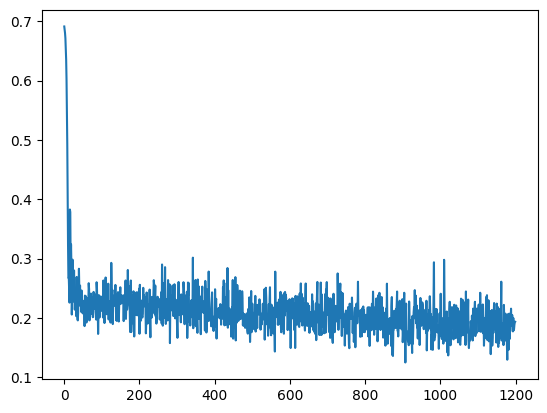

In [93]:
plt.plot(loss_record)

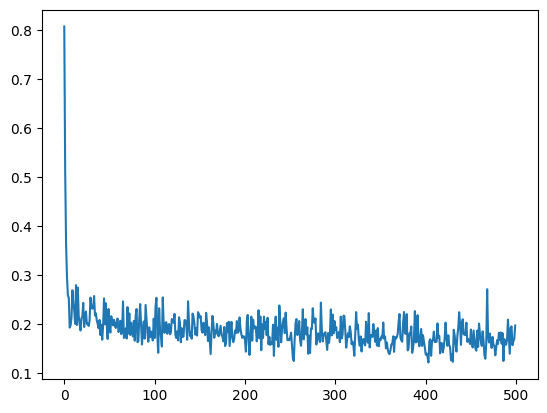

In [97]:
plt.plot(loss_record)

In [98]:
def get_accuracy(pred, target, threshold=0.5):
  assert pred.shape == target.shape
  thresholded_pred = pred > threshold
  num_correct_pred = (thresholded_pred == target).sum()
  num_entire_pred = pred.numel()

  acc = num_correct_pred / num_entire_pred
  return acc.item()

def get_f1_score(pred, target, threshold=0.5):
  assert pred.shape == target.shape
  thresholded_pred = pred > threshold
  num_true_positive = (thresholded_pred * target).sum()
  num_positive_preds = thresholded_pred.sum()
  num_true_target = target.sum()

  precision = num_true_positive / num_positive_preds
  recall = num_true_positive / num_true_target

  f1 = 2 * precision * recall / (precision + recall)
  return f1.item()

for i in range(100):
  print(i/100, get_f1_score(pred, labels, threshold=i/100))


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [99]:
valid_set = MTATDataset(data_dir, split='valid')
print(len(valid_set))
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=50, shuffle=False)

threshold = 0.14
total_tp = 0
total_pos_preds = 0
total_t_target = 0

model.eval()
with torch.inference_mode():
  for batch in valid_loader:
    audios, labels = batch
    audios, labels = audios.to(device), labels.to(device)
    pred = model(audios)
    # print(get_accuracy(pred, labels), get_accuracy(torch.zeros_like(pred), labels))

    thresholded_pred = pred > threshold
    num_true_positive = (thresholded_pred * target).sum().item()
    num_positive_preds = thresholded_pred.sum().item()
    num_true_target = target.sum().item()

    total_tp += num_true_positive
    total_pos_preds += num_positive_preds
    total_t_target += num_true_target


# model.train()
precision = total_tp / total_pos_preds
recall = total_tp / total_t_target

f1 = 2 * precision * recall / (precision + recall)
f1


1000


0.17093728927848956

In [70]:
test_set = MTATDataset(data_dir, split='test')
len(test_set)
idx = 0
info = test_set.labels.iloc[idx]
mp3_path = test_set.dir / info['mp3_path']

y, sr = torchaudio.load(mp3_path)

In [71]:
ipd.Audio(y, rate= sr )

In [89]:
torch.tensor([0.15] * 50).shape, pred.shape

(torch.Size([50]), torch.Size([1, 50]))

In [91]:
# applying different threshold to each tag
pred.cpu() > torch.tensor([0.001] + [0.15] * 49).unsqueeze(0)

tensor([[ True, False, False, False, False, False, False, False, False, False,
         False, False, False,  True, False, False,  True, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False,  True, False,  True,  True,
         False, False, False, False,  True, False, False, False, False, False]])

In [83]:
threshold = 0.18
pred = model(y.to(device))
test_set.vocab[torch.where(pred > threshold)[1].cpu()]

array(['ambient', 'slow', 'vocal'], dtype=object)

In [92]:
pred

tensor([[0.0768, 0.0025, 0.0467, 0.0115, 0.0309, 0.0222, 0.0204, 0.0890, 0.0480,
         0.1325, 0.0084, 0.0118, 0.0039, 0.2000, 0.0864, 0.1376, 0.1621, 0.0259,
         0.0264, 0.0495, 0.0027, 0.0944, 0.0356, 0.0100, 0.1481, 0.0221, 0.0298,
         0.0333, 0.0275, 0.0070, 0.0020, 0.0578, 0.0395, 0.1044, 0.0047, 0.0299,
         0.2023, 0.1453, 0.2038, 0.1512, 0.1283, 0.0196, 0.0438, 0.0043, 0.1577,
         0.0506, 0.0685, 0.0153, 0.0104, 0.0011]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)

In [59]:
target = labels
threshold= 0.5

thresholded_pred = pred > threshold
num_correct_pred = (thresholded_pred == target).sum()
num_entire_pred = pred.numel()

acc = num_correct_pred / num_entire_pred
acc.item()

0.9296000003814697

In [51]:
pred.shape, labels.shape

(torch.Size([50, 50]), torch.Size([16, 50]))

## Data Normalization

## How CNN works

## Batch Norm